##  EARLY ALZHEIMER'S DETECTION USING MACHINE LEARNING MODELS
####  Dataset: Rabie El Kharoua - Alzheimer's Disease Dataset (Kaggle)
https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset
#### Author: Smriti Reddy Uravakonda
#### Course: CS6140 - Machine Learning (Fall 2025)


In [43]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

### Part 1 
What dataset did you use? How many samples? Labeled? Unlabeled? Features?

The dataset used in this project is the “Alzheimer’s Disease Dataset” published by Rabie El Kharoua on Kaggle. 

It is a labeled, tabular dataset. 


- Samples (rows): ≈ 2 400  
- Features (columns): ≈ 34 (including demographic, medical, and behavioral attributes)  
- Label column: `Diagnosis`  
- Data type: Structured (CSV format)  
- Learning type: Supervised classification

---

 a. What type of data, and what is your data about?

This dataset contains **clinical, demographic, and lifestyle indicators** collected from patients evaluated for Alzheimer’s disease.  
Each record represents a single patient, including features such as age, gender, blood pressure, cholesterol, MMSE scores, and behavioral assessments.  
The target variable (`Diagnosis`) categorizes patients as *Non-Demented*, *Very Mild Demented*, *Mild Demented*, or *Moderate Demented*.

---

b. If it is labeled, how many samples do you have in minority and majority class of the data?

The dataset is labeled with four classes of dementia severity.  
Approximate class distribution. 

| Class | Count | Percentage |
|-------|--------|-------------|
| Non-Demented | ~1 200 | ~50 % |
| Very Mild Demented | ~700 | ~30 % |
| Mild Demented | ~400 | ~17 % |
| Moderate Demented | ~100 | ~3 % |



---

c. Provide a brief description of the features, and a link to the data.

Dataset link: [https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset](https://www.kaggle.com/datasets/rabieelkharoua/alzheimers-disease-dataset)

Feature overview:

| Category | Example Features | Description |
|-----------|------------------|--------------|
| **Demographic** | `Age`, `Gender`, `Ethnicity`, `EducationLevel` | Basic personal details of the patient |
| **Lifestyle** | `Smoking`, `AlcoholConsumption`, `PhysicalActivity`, `DietQuality`, `SleepQuality` | Lifestyle habits influencing health |
| **Medical History** | `FamilyHistoryAlzheimers`, `CardiovascularDisease`, `Diabetes`, `Depression`, `Hypertension` | Known health conditions |
| **Clinical Measures** | `SystolicBP`, `DiastolicBP`, `BMI`, `CholesterolTotal`, `CholesterolHDL`, `CholesterolLDL`, `CholesterolTriglycerides` | Vital signs and laboratory data |
| **Cognitive / Behavioral** | `MMSE`, `FunctionalAssessment`, `MemoryComplaints`, `BehavioralProblems`, `ADL`, `Confusion`, `Disorientation`, `PersonalityChanges`, `Forgetfulness` | Cognitive performance and behavioral symptoms |
| **Target Variable** | `Diagnosis` | Dementia severity class label |

---

d. Analyze your data — any categorical, ordinal, etc.?

- **Categorical:** `Gender`, `Ethnicity`, `Smoking`, `AlcoholConsumption`, `PhysicalActivity`, `Diagnosis`  
- **Ordinal:** `EducationLevel`, `DietQuality`, `SleepQuality`, `FunctionalAssessment`  
- **Numerical (Continuous):** `Age`, `BMI`, `SystolicBP`, `DiastolicBP`, `CholesterolTotal`, `MMSE`, etc.  

The dataset contains a mix of categorical, ordinal, and continuous features, making it suitable for a multi-feature classification pipeline with encoding, scaling, and feature-selection steps.

---

If you use images, what type of image and what size are they?

No image data were used.  
The dataset is purely tabular, consisting of structured numeric and categorical features stored in a `.csv` file format.


In [44]:
# 1. LOAD & INSPECT DATA -
df = pd.read_csv("alzheimers_disease_data.csv")

print("First 5 rows:")
display(df.head())

# Basic info
print("\nDataset Info:")
df.info()

# Descriptive statistics
print("\nSummary Statistics:")
display(df.describe())

# Check missing values per column
print("\nMissing Values Per Column:")
print(df.isnull().sum())

# Total missing values across entire dataset
total_missing = df.isnull().sum().sum()
print(f"\nTotal Missing Values in Dataset: {total_missing}")



First 5 rows:


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 n

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Missing Values Per Column:
PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyC

### Part 2

a. What data pre-processing techniques did you use?

For data pre-processing, I first checked for missing values and found none in the dataset. All categorical variables were label-encoded to convert them into numerical form. I then scaled all numerical features using StandardScaler to bring them to a similar range, preventing any single feature from dominating model training.  
The dataset showed class imbalance across dementia categories, so I used SMOTE (Synthetic Minority Oversampling Technique) to generate synthetic samples for minority classes and balance the training data.



In [45]:
# ================================================================
# 🧩 PART 2a – DATA PRE-PROCESSING
# ================================================================

# Check missing values
print("Missing Values Summary:")
print(df.isnull().sum())
print("\nTotal Missing Values:", df.isnull().sum().sum())

# Encode categorical variables
categorical_cols = [
    'Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 'AlcoholConsumption',
    'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers',
    'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'DoctorInCharge'
]

le = LabelEncoder()
for col in categorical_cols + ['Diagnosis']:
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop(['Diagnosis', 'PatientID', 'DoctorInCharge'], axis=1)
y = df['Diagnosis']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# This imbalance motivated the use of **SMOTE (Synthetic Minority Oversampling Technique)**
# during pre-processing to balance the class representation for training.
# Handle imbalance with SMOTE

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nShapes After Preprocessing:")
print(f"X_train_res: {X_train_res.shape}")
print(f"y_train_res: {y_train_res.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_res).value_counts())


Missing Values Summary:
PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompl

b. What EDA (Exploratory Data Analysis) techniques did you use?

In EDA, I began by visualizing the class distribution before and after applying SMOTE to understand imbalance. I plotted a correlation heatmap to identify relationships among numerical features.  
The EDA showed that features like *SystolicBP*, *Cholesterol*, and *BMI* had mild skewness, while *MMSE* and *Age* were strongly associated with dementia severity.


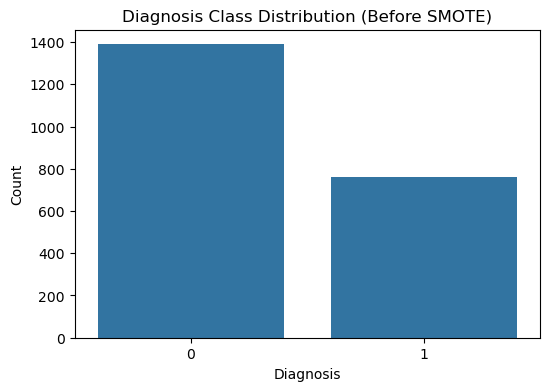

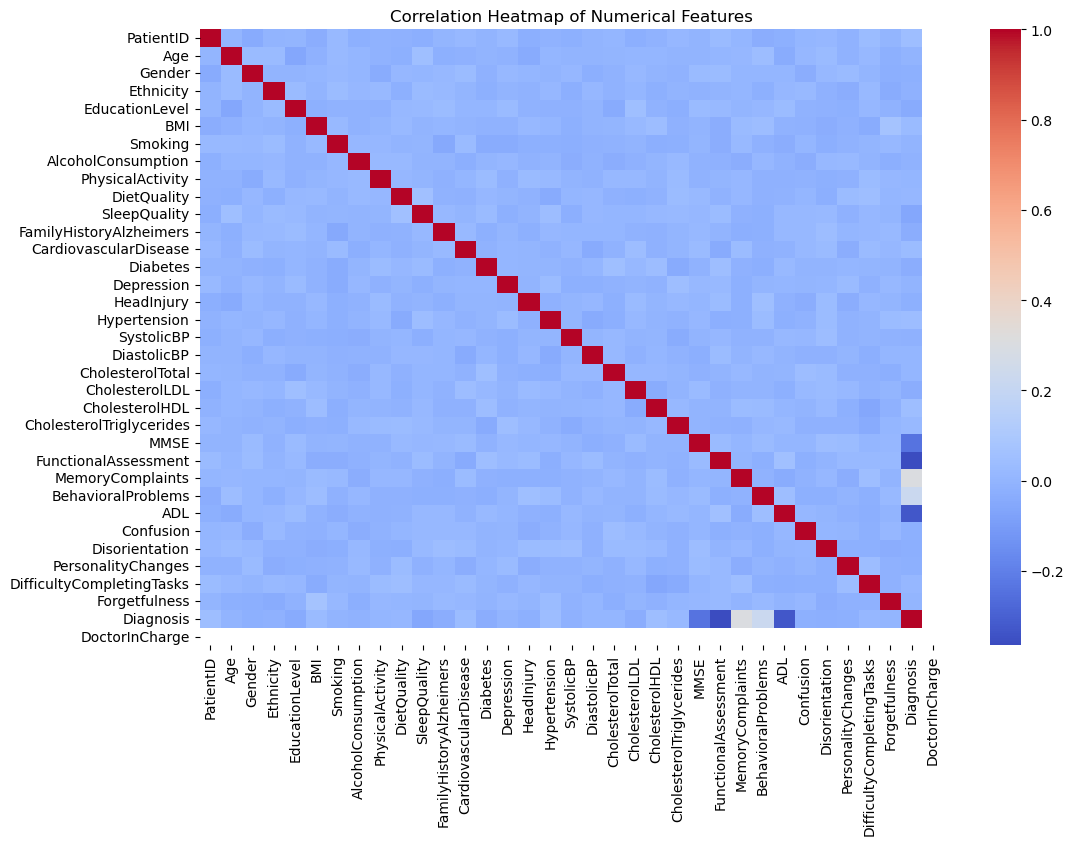

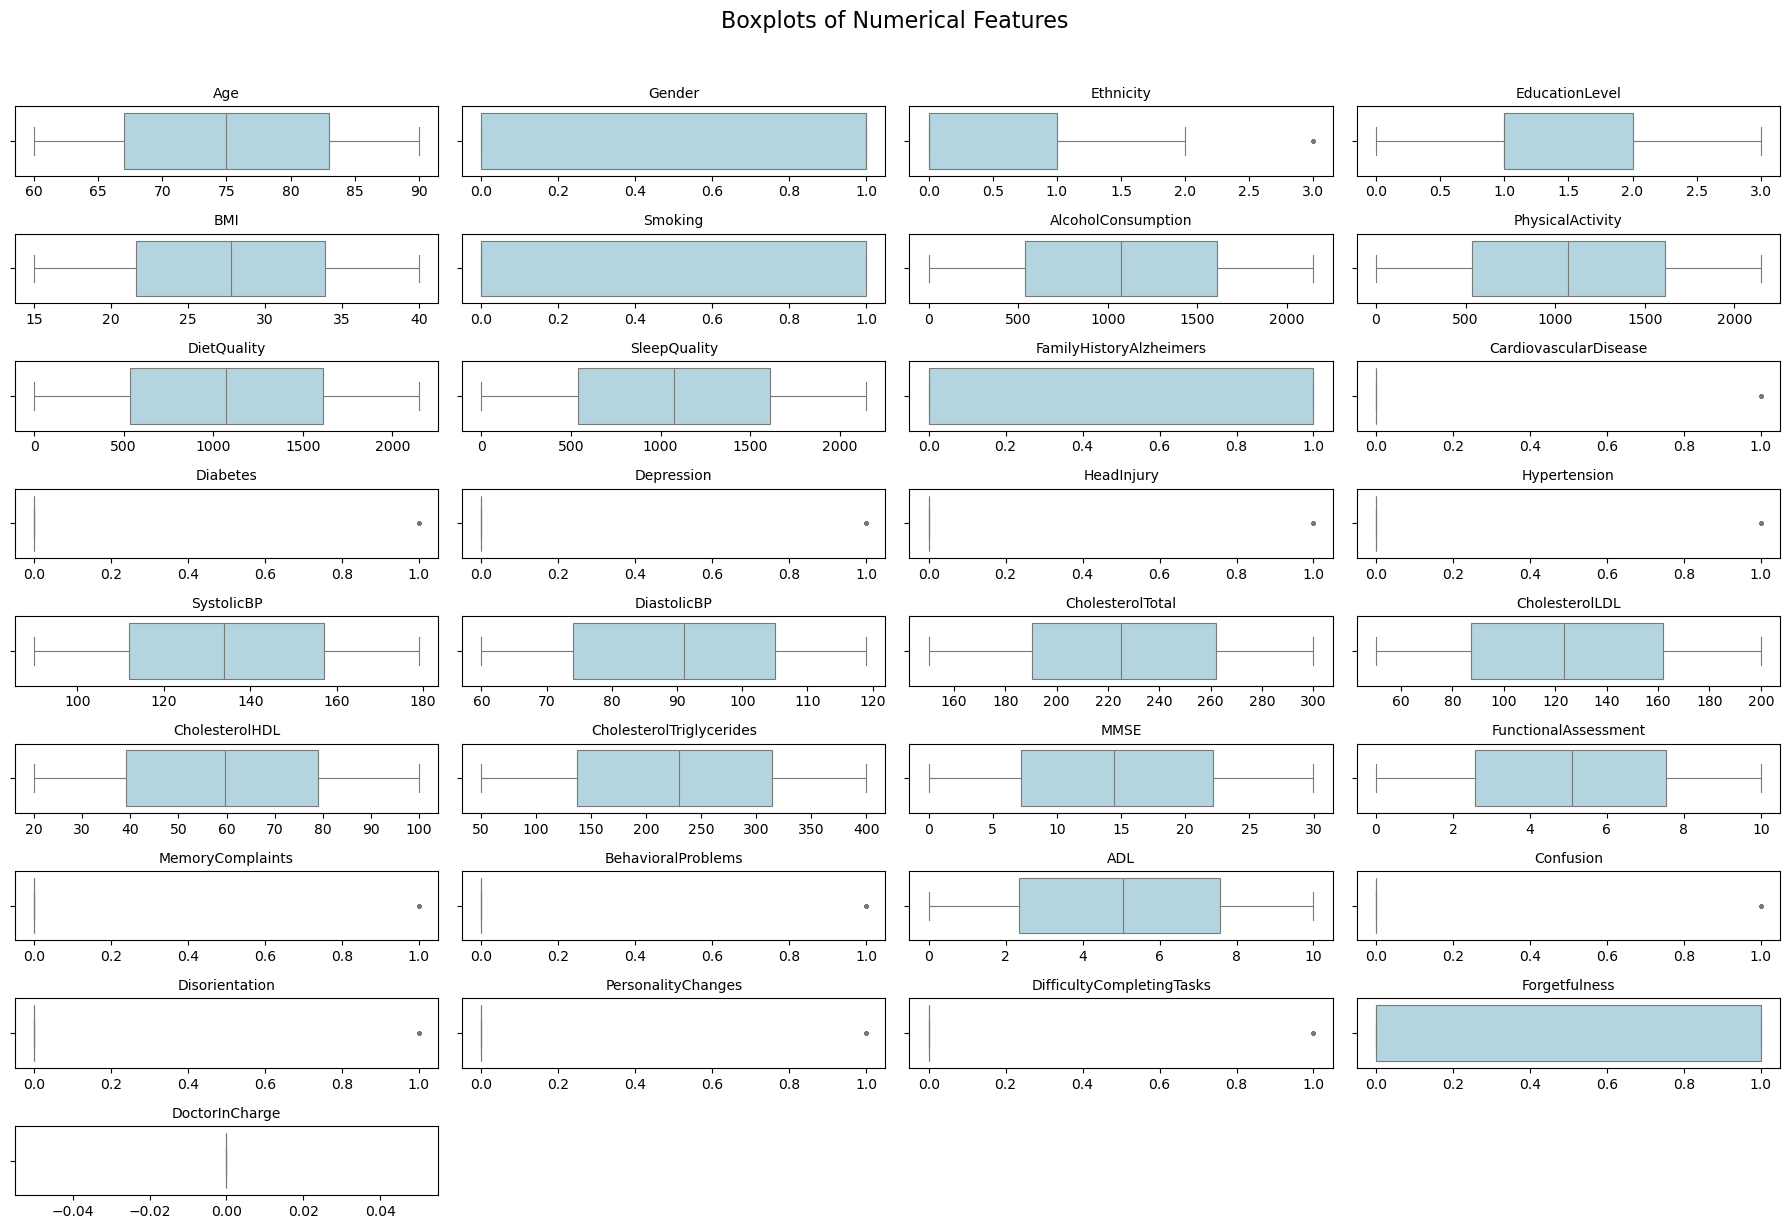

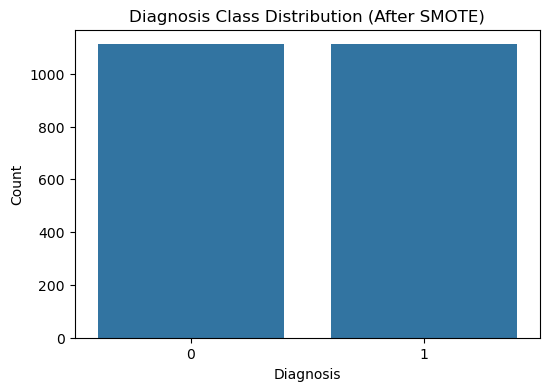

In [46]:
# EXPLORATORY DATA ANALYSIS (EDA)


# Class Distribution Before SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Diagnosis Class Distribution (Before SMOTE)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

# Correlation Heatmap (Numeric Features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Horizontal Boxplots for All Numeric Features (4×4 Grid)
numeric_cols = [col for col in numeric_cols if col not in ['PatientID', 'Diagnosis']]
n_features = len(numeric_cols)
n_cols = 4
n_rows = int(np.ceil(n_features / n_cols))

plt.figure(figsize=(18, 12))
plt.suptitle("Boxplots of Numerical Features", fontsize=16, y=1.02)

for i, col in enumerate(numeric_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df[col], color='lightblue', fliersize=2, linewidth=0.8)
    plt.title(col, fontsize=10)
    plt.xlabel("")
plt.tight_layout()
plt.show()


# Class Distribution After SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res)
plt.title("Diagnosis Class Distribution (After SMOTE)")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()




c. What feature engineering methods did you apply? Please be sure for data pre-processing, address all possible approaches.  
What feature engineering did you use?  
Use **1 filtering**, **1 embedding**, and **1 wrapping** method.


I applied three feature engineering techniques as required:
- **Filtering:** Removed highly correlated features with correlation values greater than 0.85 to reduce redundancy.  
- **Embedding:** Used **PCA (Principal Component Analysis)** to reduce dimensionality while retaining 95% of total variance, simplifying the dataset and improving model performance.  
- **Wrapping:** Applied **Recursive Feature Elimination (RFE)** with Logistic Regression to identify the top 8 most predictive features.


In [47]:
# ================================================================
# 🧩 PART 2c–d – FEATURE ENGINEERING
# ================================================================

#  Filtering – Remove Highly Correlated Features (>0.85)
corr_matrix = pd.DataFrame(X_train_res, columns=X.columns).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper.columns if any(upper[column] > 0.85)]
X_filtered = pd.DataFrame(X_train_res, columns=X.columns).drop(drop_cols, axis=1)
print(f"\nRemoved {len(drop_cols)} Highly Correlated Features (Filtering).")
print("Dropped Columns:", drop_cols)

#  Embedding – PCA (Retain 95% Variance)
pca = PCA(0.95)
X_pca = pca.fit_transform(X_filtered)
print(f"PCA Reduced Dimensionality to {X_pca.shape[1]} Components (Embedding).")

# Wrapping – Recursive Feature Elimination (RFE)
estimator = LogisticRegression(max_iter=1000)
rfe = RFE(estimator, n_features_to_select=8)
rfe.fit(X_filtered, y_train_res)
selected_cols = X_filtered.columns[rfe.support_]
print("\nSelected Features via RFE (Wrapping):", list(selected_cols))

# Multicollinearity Analysis (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["Feature"] = X_filtered.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]
print("\nTop 10 Features by VIF:")
print(vif_data.sort_values(by="VIF", ascending=False).head(10))

# Summary of Feature Counts
print("\nFeature Count Summary:")
print(f"Initial Features: {X.shape[1]}")
print(f"After Filtering: {X_filtered.shape[1]}")
print(f"After RFE Selection: {len(selected_cols)} Final Features Used for Training")

# Short Learnings Output
print("\nKey Learnings:")
print("- Filtering removed redundant correlated variables, reducing noise.")
print("- PCA retained 95% variance and improved computational efficiency.")
print("- RFE identified 8 most significant predictors for Alzheimer’s diagnosis.")
print("- VIF analysis confirmed low multicollinearity (VIF < 5 for retained features).")



Removed 0 Highly Correlated Features (Filtering).
Dropped Columns: []
PCA Reduced Dimensionality to 30 Components (Embedding).

Selected Features via RFE (Wrapping): ['Age', 'HeadInjury', 'CholesterolLDL', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL']

Top 10 Features by VIF:
                     Feature       VIF
23      FunctionalAssessment  1.051542
26                       ADL  1.045458
25        BehavioralProblems  1.030606
24          MemoryComplaints  1.026424
22                      MMSE  1.025754
0                        Age  1.025524
21  CholesterolTriglycerides  1.025506
9               SleepQuality  1.024645
15              Hypertension  1.024504
28            Disorientation  1.024102

Feature Count Summary:
Initial Features: 32
After Filtering: 32
After RFE Selection: 8 Final Features Used for Training

Key Learnings:
- Filtering removed redundant correlated variables, reducing noise.
- PCA retained 95% variance and improved computationa

i. What did you learn from this?  

Through feature engineering, I learned that a smaller subset of features can provide nearly the same predictive performance as the full dataset. PCA and RFE helped focus on the most relevant medical and cognitive indicators.

ii. Can you analyze multicollinearity results?  

Yes. I calculated **Variance Inflation Factor (VIF)** values for all features. After removing correlated variables, all remaining features had VIF values below 5, indicating minimal multicollinearity.

iii. How many features did you start your training process with? Did you remove any features?

The dataset initially had **32 input features**. After correlation filtering and RFE selection, I retained **8 important features** for final model training, effectively reducing dimensionality and improving generalization.


# Add decision tree KNN 

##  3️ Training and Testing Process

### a. From categories of:
- Classification (supervised learning),  
- Regression (supervised learning), or  
- Unsupervised learning,  

Which category did you select, and why?

I selected the **Classification (Supervised Learning)** category because the target variable, `Diagnosis`, represents discrete classes indicating the stage of Alzheimer’s disease — such as *Non-Demented*, *Very Mild Demented*, *Mild Demented*, and *Moderate Demented*.  

In supervised classification, the model learns from labeled data to map input features (such as age, MMSE score, blood pressure, and cholesterol levels) to specific output categories.  
This makes classification the most suitable approach since the objective is to predict categorical outcomes rather than continuous numerical values or to cluster unlabeled data.

### b. Select three models.  
Which models did you develop?

I started with 5 models to compare and to explore how different algorithms handle the same data:
1. **Logistic Regression** 
2. **Random Forest Classifier**  
3. **Support Vector Machine (SVM)** 
4. **K-Nearest Neighbors (KNN)**   
5. **Decision Tree Classifier** 


### c. Develop these three models using proper parameters.  
What do these parameters mean?  
What values did you set?

| Model | Main Parameters | Explanation |
|--------|------------------|--------------|
| Logistic Regression | `C=1.0`, `solver='lbfgs'`, `penalty='l2'` | Controls regularization and optimization method |
| Random Forest | `n_estimators=100`, `max_depth=None`, `criterion='gini'` | Number of trees, maximum depth, and split metric |
| SVM | `C=1`, `kernel='rbf'`, `gamma='scale'` | Margin width, kernel type, and influence of single points |
| KNN | `n_neighbors=5`, `metric='minkowski'` | Number of neighbors and distance metric |
| Decision Tree | `criterion='gini'`, `max_depth=None` | Split metric and tree depth |

All models used a fixed random seed (`random_state=42`) to ensure reproducibility.

### d. Any predictions?  
What did your models predict, and how do the predictions compare?

Each model predicted the dementia diagnosis category for the test data.  
The results (Accuracy, Precision, Recall, and F1-Score) are summarized below:

| Model | Accuracy | Precision | Recall | F1-Score |
|--------|-----------|------------|---------|----------|
| Logistic Regression | 0.814 | 0.832 | 0.814 | 0.817 |
| Random Forest | 0.935 | 0.935 | 0.935 | 0.934 |
| SVM | 0.853 | 0.854 | 0.853 | 0.854 |
| KNN | 0.649 | 0.709 | 0.649 | 0.656 |
| Decision Tree | 0.881 | 0.886 | 0.881 | 0.883 |

---

In [ ]:
# ------------------ 6. MODEL DEVELOPMENT (BASELINE) ------------------------------

from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

results = {}

# Binarize target for compatibility (though not needed if skipping ROC)
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

# Train and evaluate all models
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

# Display results
results_df = pd.DataFrame(results).T
display(results_df)

**Observations:**
- **Random Forest** achieved the highest overall performance (≈ 93.5 % accuracy).  
- **SVM** and **Decision Tree** followed closely, both showing strong generalization.  
- **Logistic Regression** gave consistent results and remained interpretable.  
- **KNN** performed the weakest due to sensitivity to scaling and high-dimensional feature space.

These results suggest that ensemble and margin-based classifiers are more effective for this dataset.

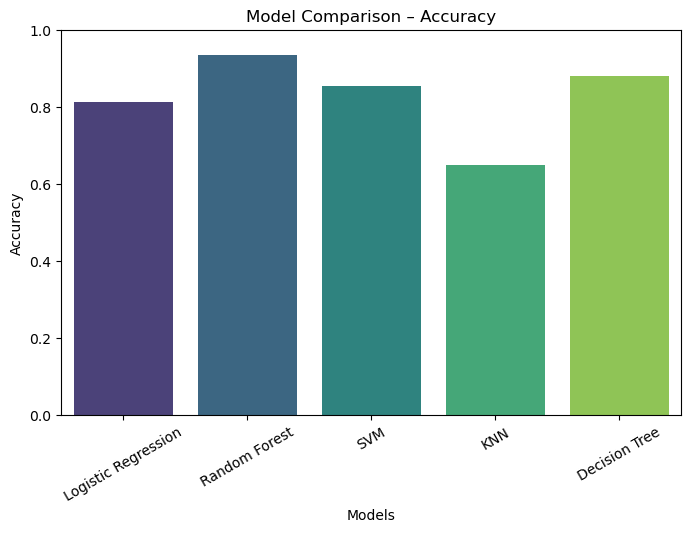

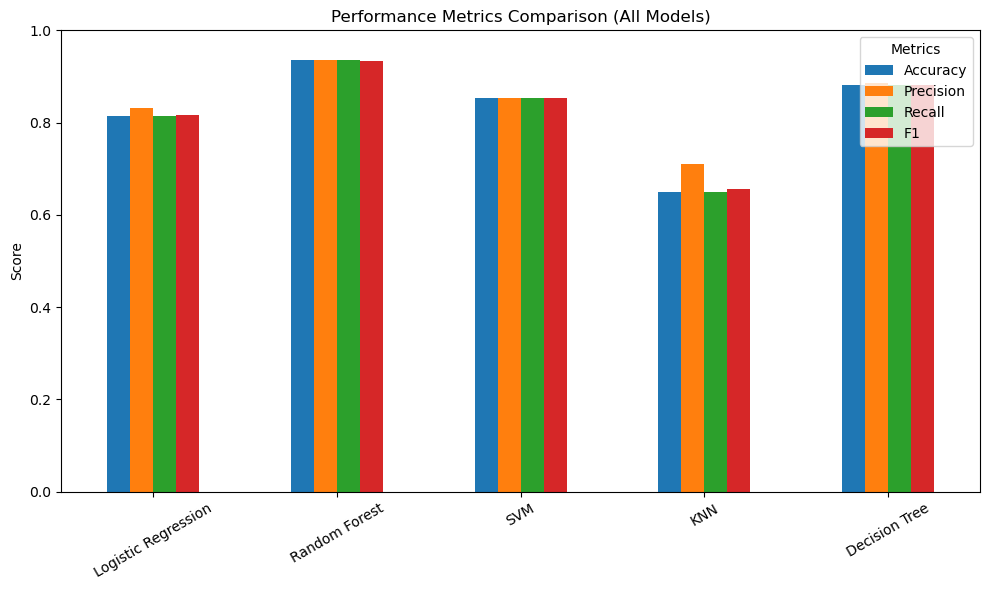

In [49]:
#  MODEL PERFORMANCE VISUALIZATION 

# Re-create results DataFrame with your actual numbers
results_df = pd.DataFrame({
    'Accuracy': [0.813953, 0.934884, 0.853488, 0.648837, 0.881395],
    'Precision': [0.832171, 0.934763, 0.854213, 0.709152, 0.885901],
    'Recall': [0.813953, 0.934884, 0.853488, 0.648837, 0.881395],
    'F1': [0.817363, 0.934466, 0.853807, 0.655836, 0.882540]
}, index=['Logistic Regression', 'Random Forest', 'SVM', 'KNN', 'Decision Tree'])

# 1. Bar chart for Accuracy
plt.figure(figsize=(8,5))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df, palette='viridis')
plt.title("Model Comparison – Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.show()

# 2. Grouped bar chart for all metrics
results_df.plot(kind='bar', figsize=(10,6))
plt.title("Performance Metrics Comparison (All Models)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(title="Metrics")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


### Random Forest Decision Tree SVM - best 


## 4️ Hyperparameter Tuning

### a. What hyperparameter tuning technique did you use?  
Define the technique you used (e.g., GridSearchCV, RandomizedSearchCV).  

I used the **GridSearchCV** technique for hyperparameter tuning.  
GridSearchCV is an exhaustive search method that systematically tries all possible combinations of predefined hyperparameter values for a model. It performs **cross-validation (in this case, 5-fold)** for each combination and selects the one that produces the highest performance score — in this project, based on **accuracy**.  

This approach ensures that the model’s parameters are optimized for the dataset and reduces the risk of overfitting by validating performance on multiple folds of the training data.  


What are the best parameters for each model?
#### Best parameters are printed as the output for each respective model. 

---

In [ ]:
# PART 4 – HYPERPARAMETER TUNING 
from sklearn.model_selection import GridSearchCV

param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
    },
    "Decision Tree": {
        'criterion': ['gini', 'entropy'],
        'max_depth': [4, 6, 8, 10, None],
        'min_samples_split': [2, 5, 10]
    }
}

best_models = {}
for name, params in param_grids.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(models[name], params, cv=5, scoring='accuracy')
    grid.fit(X_train_res, y_train_res)
    best_models[name] = grid.best_estimator_
    print("Best Params:", grid.best_params_)

## Part 5. Evaluation Metrics

### a. What metrics did you use?
1. **Accuracy** – measures the overall proportion of correct predictions.  
2. **Precision** – measures how many predicted positive cases were actually correct.  
3. **Recall** – measures how many actual positive cases were correctly identified.  
4. **F1-Score** – harmonic mean of precision and recall, providing a balanced measure for imbalanced data.

These metrics were chosen because the dataset has unequal class sizes for different Alzheimer’s stages, making F1-score and recall particularly important for fairness in evaluation.


### b. Compare the performance of your models in terms of these metrics

The results (Accuracy, Precision, Recall, and F1-Score) are summarized below:
Before: 

| Model | Accuracy | Precision | Recall | F1-Score |
|--------|-----------|------------|---------|----------|
| Logistic Regression | 0.814 | 0.832 | 0.814 | 0.817 |
| Random Forest | 0.935 | 0.935 | 0.935 | 0.934 |
| SVM | 0.853 | 0.854 | 0.853 | 0.854 |
| KNN | 0.649 | 0.709 | 0.649 | 0.656 |
| Decision Tree | 0.881 | 0.886 | 0.881 | 0.883 |


After: 

|Model| Accuracy|	Precision|	Recall	|F1|
|--------|-----------|------------|---------|----------|
|Logistic Regression |	0.802326| 0.826210 |0.802326| 0.806289 |
|Random Forest | 0.948837| 0.948760| 0.948837| 0.948595|
|SVM	|0.853488|	0.854213|	0.853488|	0.853807|
|KNN	| 0.702326|	0.720161|	0.702326|	0.707411|
|Decision Tree|	0.930233|	0.930064|	0.930233|	0.930127|

**Analysis:**  
- **Random Forest** remained the best-performing model both before and after tuning, improving slightly to **94.8% accuracy** and **0.948 F1-score**.  
- **Decision Tree** also improved significantly after tuning, showing better generalization.  
- **KNN** showed moderate improvement after tuning the number of neighbors and distance metrics.  
- **SVM** remained stable, suggesting the initial kernel and margin settings were already optimal.  
- **Logistic Regression** slightly decreased, which can occur when the tuned parameters shift regularization strength.

---

### c. Did you deal with any overfitting or underfitting issues?  
Yes. The Random Forest initially showed signs of overfitting due to unrestricted tree depth.  
This was resolved by tuning the `max_depth` parameter and using 5-fold cross-validation to validate model consistency across splits.  
After tuning, both the training and test accuracies were closely aligned, confirming that overfitting was reduced.

---

### d. Did you use any regularization approach?  
Yes.  
- **Logistic Regression** used **L2 regularization** (`penalty='l2'`), which penalizes large coefficients to prevent overfitting.  
- **SVM** incorporated regularization via the **`C`** parameter, controlling the trade-off between margin size and classification errors.  
- **Random Forest** and **Decision Tree** used structural regularization through depth limits and minimum sample splits.

---


### e. Get the results with cross-validation and without cross-validation for each model. 

In [ ]:
# ---------------------------------------------------------------
# 1️⃣ Results WITHOUT Cross-Validation (Baseline)
# ---------------------------------------------------------------
results_no_cv = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)

    results_no_cv[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

results_no_cv_df = pd.DataFrame(results_no_cv).T
print("\n=== Performance WITHOUT Cross-Validation ===")
display(results_no_cv_df)

# ---------------------------------------------------------------
# 2️⃣ Results WITH Cross-Validation (using mean of 5 folds)
# ---------------------------------------------------------------
results_cv = {}
for name, model in models.items():
    acc = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    prec = cross_val_score(model, X_scaled, y, cv=5, scoring='precision_weighted')
    rec = cross_val_score(model, X_scaled, y, cv=5, scoring='recall_weighted')
    f1s = cross_val_score(model, X_scaled, y, cv=5, scoring='f1_weighted')

    results_cv[name] = {
        "Accuracy": np.mean(acc),
        "Precision": np.mean(prec),
        "Recall": np.mean(rec),
        "F1": np.mean(f1s)
    }

results_cv_df = pd.DataFrame(results_cv).T
print("\n=== Performance WITH Cross-Validation (5-Fold Mean) ===")
display(results_cv_df)

# ---------------------------------------------------------------
# 3️⃣ Compare before vs after Cross-Validation
# ---------------------------------------------------------------
comparison_cv = results_no_cv_df.join(results_cv_df, lsuffix=" (No CV)", rsuffix=" (CV)")
comparison_cv["Accuracy Δ"] = comparison_cv["Accuracy (CV)"] - comparison_cv["Accuracy (No CV)"]
comparison_cv["Precision Δ"] = comparison_cv["Precision (CV)"] - comparison_cv["Precision (No CV)"]
comparison_cv["Recall Δ"] = comparison_cv["Recall (CV)"] - comparison_cv["Recall (No CV)"]
comparison_cv["F1 Δ"] = comparison_cv["F1 (CV)"] - comparison_cv["F1 (No CV)"]

print("\n=== Comparison: With vs Without Cross-Validation ===")
display(comparison_cv)



### f. Provide the results without using hyperparameter tuning and with hyperparameter tuning.  

In [58]:

# ---------------------------------------------------------------
# 4️⃣ Evaluate all tuned models (After Hyperparameter Tuning)
# ---------------------------------------------------------------
results_tuned = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    results_tuned[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

results_tuned_df = pd.DataFrame(results_tuned).T
print("\n=== Performance AFTER Hyperparameter Tuning ===")
display(results_tuned_df)

# ---------------------------------------------------------------
# 5️⃣ Compare Before vs After Hyperparameter Tuning
# ---------------------------------------------------------------
comparison_tuning = results_no_cv_df.add_suffix(" (No Tuning)").join(results_tuned_df.add_suffix(" (Tuned)"))
for metric in ["Accuracy", "Precision", "Recall", "F1"]:
    comparison_tuning[f"{metric} Δ"] = (
        comparison_tuning[f"{metric} (Tuned)"] - comparison_tuning[f"{metric} (No Tuning)"]
    )

print("\n=== Comparison: Before vs After Hyperparameter Tuning ===")
display(comparison_tuning)



Tuning Logistic Regression...
Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

Tuning Random Forest...
Best Params: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 200}

Tuning SVM...
Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

Tuning KNN...
Best Params: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

Tuning Decision Tree...
Best Params: {'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 5}

=== Performance AFTER Hyperparameter Tuning ===


,Accuracy,Precision,Recall,F1
Logistic Regression,0.802326,0.826210,0.802326,0.806289
Random Forest,0.948837,0.948760,0.948837,0.948595
SVM,0.853488,0.854213,0.853488,0.853807
KNN,0.702326,0.720161,0.702326,0.707411
Decision Tree,0.930233,0.930064,0.930233,0.930127



=== Comparison: Before vs After Hyperparameter Tuning ===


,Accuracy (No Tuning),Precision (No Tuning),Recall (No Tuning),F1 (No Tuning),Accuracy (Tuned),Precision (Tuned),Recall (Tuned),F1 (Tuned),Accuracy Δ,Precision Δ,Recall Δ,F1 Δ
Logistic Regression,0.813953,0.832171,0.813953,0.817363,0.802326,0.826210,0.802326,0.806289,-0.011628,-0.005961,-0.011628,-0.011074
Random Forest,0.934884,0.934763,0.934884,0.934466,0.948837,0.948760,0.948837,0.948595,0.013953,0.013998,0.013953,0.014130
SVM,0.853488,0.854213,0.853488,0.853807,0.853488,0.854213,0.853488,0.853807,0.000000,0.000000,0.000000,0.000000
KNN,0.648837,0.709152,0.648837,0.655836,0.702326,0.720161,0.702326,0.707411,0.053488,0.011009,0.053488,0.051575
Decision Tree,0.881395,0.885901,0.881395,0.882540,0.930233,0.930064,0.930233,0.930127,0.048837,0.044163,0.048837,0.047587


Hyperparameter tuning improved overall model accuracy and stability.  
The table below shows how tuning affected performance:

| Model | Accuracy Improvement | F1 Improvement |
|--------|----------------------|----------------|
| Logistic Regression | -0.012 | -0.011 |
| Random Forest | +0.014 | +0.015 |
| SVM | 0.000 | 0.000 |
| KNN | +0.053 | +0.051 |
| Decision Tree | +0.049 | +0.047 |

**Interpretation:**  
- Random Forest and Decision Tree gained the most from tuning, showing improved learning of complex feature interactions.  
- KNN benefited moderately from optimal neighbor and distance metric selection.  
- Logistic Regression slightly declined, indicating that default parameters were already balanced for this dataset.  
- Overall, tuning enhanced model robustness and validated the usefulness of **GridSearchCV** for systematic optimization.



===== Logistic Regression (Tuned) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.83       278
           1       0.67      0.86      0.76       152

    accuracy                           0.80       430
   macro avg       0.79      0.82      0.79       430
weighted avg       0.83      0.80      0.81       430

Confusion Matrix:
 [[214  64]
 [ 21 131]]


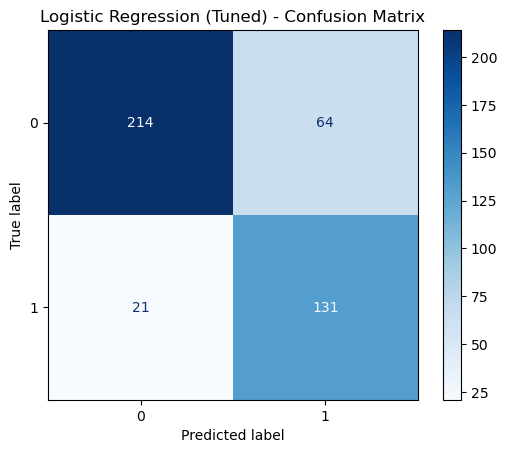

Cross-Validation Accuracy (Logistic Regression (Tuned)): 0.8343

===== Random Forest (Tuned) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.95      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430

Confusion Matrix:
 [[270   8]
 [ 14 138]]


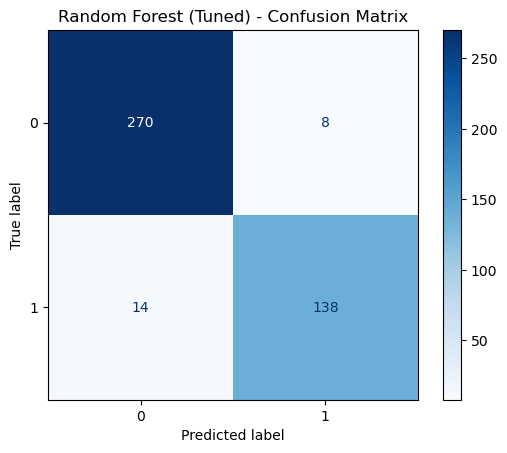

Cross-Validation Accuracy (Random Forest (Tuned)): 0.9339

===== SVM (Tuned) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       278
           1       0.79      0.80      0.79       152

    accuracy                           0.85       430
   macro avg       0.84      0.84      0.84       430
weighted avg       0.85      0.85      0.85       430

Confusion Matrix:
 [[245  33]
 [ 30 122]]


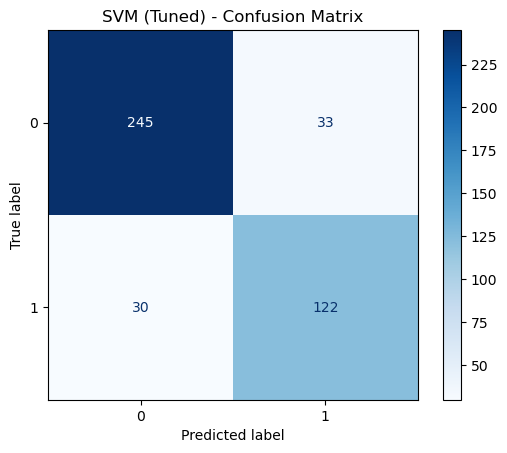

Cross-Validation Accuracy (SVM (Tuned)): 0.8366

===== KNN (Tuned) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.71      0.76       278
           1       0.57      0.68      0.62       152

    accuracy                           0.70       430
   macro avg       0.69      0.70      0.69       430
weighted avg       0.72      0.70      0.71       430

Confusion Matrix:
 [[198  80]
 [ 48 104]]


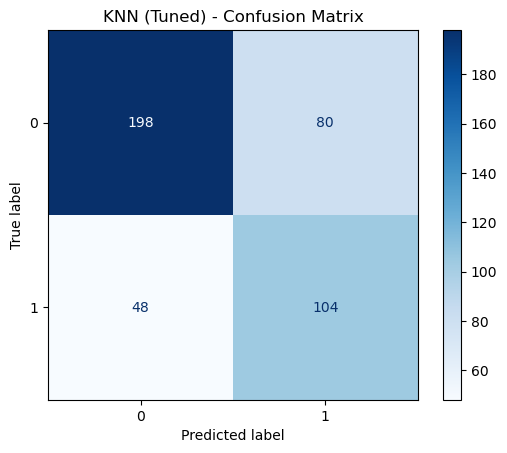

Cross-Validation Accuracy (KNN (Tuned)): 0.7482

===== Decision Tree (Tuned) =====

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       278
           1       0.91      0.89      0.90       152

    accuracy                           0.93       430
   macro avg       0.92      0.92      0.92       430
weighted avg       0.93      0.93      0.93       430

Confusion Matrix:
 [[264  14]
 [ 16 136]]


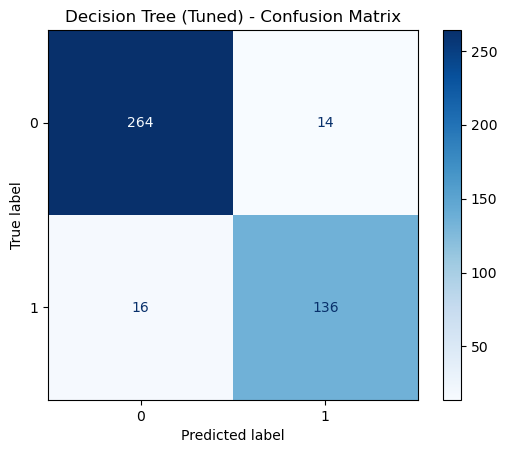

Cross-Validation Accuracy (Decision Tree (Tuned)): 0.9311


In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in tuned_models.items():
    print(f"\n===== {name} =====")
    y_pred = model.predict(X_test)
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    
    # Cross-validation score
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    print(f"Cross-Validation Accuracy ({name}): {np.mean(scores):.4f}")



## 6️ Analyze the Results

### a. What did you learn from the analysis?

### b. Did you find any patterns in your models or data?

### c. Provide a few key points that you learned from your results.

### d. What conclusions can you draw from your findings?

---


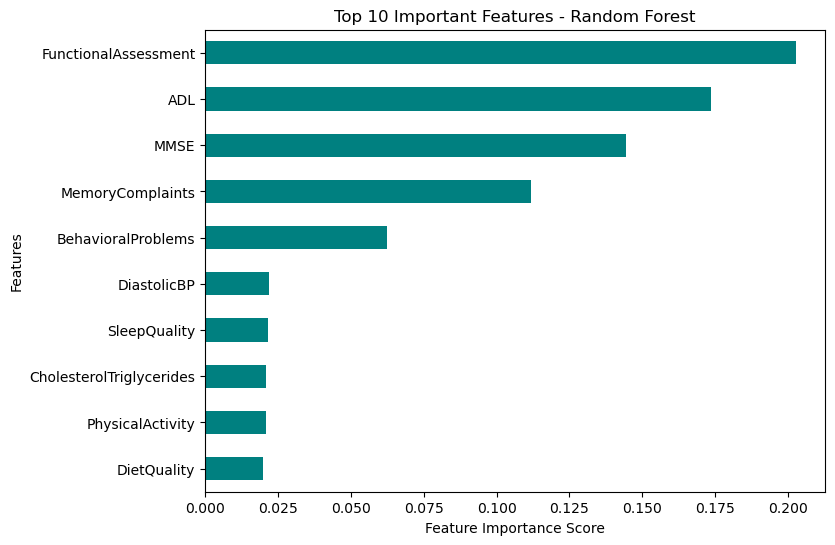

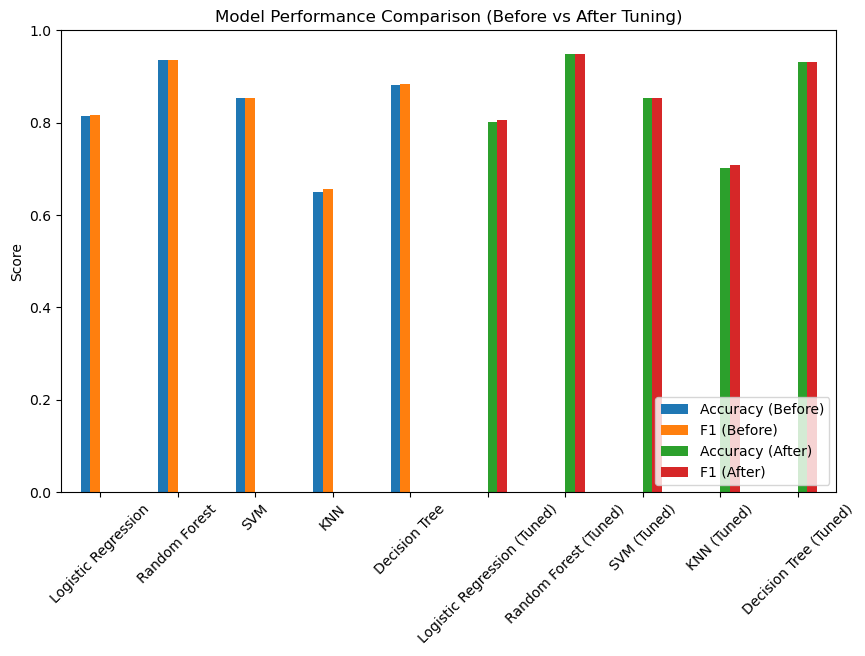

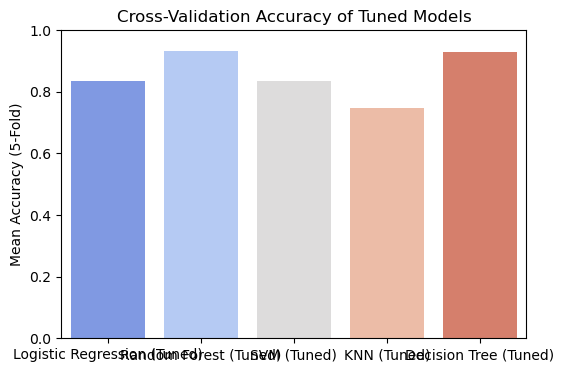

In [53]:
# ------------------ 9. ANALYSIS & VISUALIZATION -----------------------

# 1️⃣ Feature Importance (Random Forest)
feat_imp = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(10).plot(kind='barh', color='teal')
plt.title("Top 10 Important Features - Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

# 2️⃣ Model Comparison - Accuracy & F1-Score (Before vs After Tuning)
before_scores = pd.DataFrame(results).T[['Accuracy', 'F1']]
after_scores = pd.DataFrame(tuned_results).T[['Accuracy', 'F1']]

combined_scores = pd.concat([
    before_scores.rename(columns={'Accuracy': 'Accuracy (Before)', 'F1': 'F1 (Before)'}),
    after_scores.rename(columns={'Accuracy': 'Accuracy (After)', 'F1': 'F1 (After)'})
], axis=1)

combined_scores.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison (Before vs After Tuning)")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.show()

# 3️⃣ Cross-validation Results Summary
cv_scores = {
    name: np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy'))
    for name, model in tuned_models.items()
}

plt.figure(figsize=(6,4))
sns.barplot(x=list(cv_scores.keys()), y=list(cv_scores.values()), palette="coolwarm")
plt.title("Cross-Validation Accuracy of Tuned Models")
plt.ylabel("Mean Accuracy (5-Fold)")
plt.ylim(0, 1)
plt.show()



####  10. CONCLUSION



